In [1]:
%cd
!rm -rf root/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10

!rm -rf root/models
  
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

%cd ~/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/;:/content/models/research/slim/'

!python setup.py build
!python setup.py install

/root
     |████████████████████████████████| 993kB 3.4MB/s 
/root/models/research
running build
running build_py
creating build
creating build/lib
creating build/lib/object_detection
copying object_detection/model_lib_v2.py -> build/lib/object_detection
copying object_detection/model_main.py -> build/lib/object_detection
copying object_detection/model_tpu_main.py -> build/lib/object_detection
copying object_detection/eval_util.py -> build/lib/object_detection
copying object_detection/model_hparams.py -> build/lib/object_detection
copying object_detection/__init__.py -> build/lib/object_detection
copying object_detection/exporter_test.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph_lib.py -> build/lib/object_detection
copying object_detection/model_lib_v2_test.py -> build/lib/object_detection
copying object_detection/model_lib_test.py -> build/lib/object_detection
copying object_detection/inputs_test.py -> build/lib/object_detection
copying object_dete

In [2]:
%cd slim
!python setup.py build
!python setup.py install
%cd ..
!python object_detection/builders/model_builder_test.py
%cd object_detection

/root/models/research/slim
running build
running build_py
creating build
creating build/lib
creating build/lib/preprocessing
copying preprocessing/__init__.py -> build/lib/preprocessing
copying preprocessing/cifarnet_preprocessing.py -> build/lib/preprocessing
copying preprocessing/inception_preprocessing.py -> build/lib/preprocessing
copying preprocessing/preprocessing_factory.py -> build/lib/preprocessing
copying preprocessing/lenet_preprocessing.py -> build/lib/preprocessing
copying preprocessing/vgg_preprocessing.py -> build/lib/preprocessing
creating build/lib/nets
copying nets/inception_v4_test.py -> build/lib/nets
copying nets/inception_v1_test.py -> build/lib/nets
copying nets/i3d_utils.py -> build/lib/nets
copying nets/i3d.py -> build/lib/nets
copying nets/dcgan_test.py -> build/lib/nets
copying nets/mobilenet_v1.py -> build/lib/nets
copying nets/dcgan.py -> build/lib/nets
copying nets/__init__.py -> build/lib/nets
copying nets/mobilenet_v1_train.py -> build/lib/nets
copying n

In [3]:
%cd ~/models/research/object_detection
!rm -rf images

/root/models/research/object_detection


In [7]:
#images
fileId = '1SzVEs7Jlt7DndDy-ZGWD87v_lPYyd4hI'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)



Extracted zip file 1SzVEs7Jlt7DndDy-ZGWD87v_lPYyd4hI.zip


In [8]:
%cd 


/root


In [0]:
!rm -rf TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10
!git clone --quiet https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10.git

In [0]:
!mv ~/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10/xml_to_csv.py /root/models/research/object_detection/

In [0]:
!mv ~/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10/generate_tfrecord.py /root/models/research/object_detection/
!mv /root/models/research/object_detection/legacy/train.py /root/models/research/object_detection/


In [12]:
#xml to csv
%cd ~/models/research/object_detection/
!python xml_to_csv.py

/root/models/research/object_detection
Successfully converted xml to csv.
Successfully converted xml to csv.


In [0]:
!rm -rf training

In [0]:
#training directory
!mkdir training

In [0]:
%pycat generate_tfrecord.py
!rm generate_tfrecord.py

In [17]:
%%writefile generate_tfrecord.py
"""
Usage:
  # From tensorflow/models/
  # Create train data:
  python generate_tfrecord.py --csv_input=images/train_labels.csv --image_dir=images/train --output_path=train.record

  # Create test data:
  python generate_tfrecord.py --csv_input=images/test_labels.csv  --image_dir=images/test --output_path=test.record
"""
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

flags = tf.app.flags
flags.DEFINE_string('csv_input', '', 'Path to the CSV input')
flags.DEFINE_string('image_dir', '', 'Path to the image directory')
flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
FLAGS = flags.FLAGS


# TO-DO replace this with label map
def class_text_to_int(row_label):
    if row_label == 'pdone':
        return 1
    elif row_label == 'pdtwo':
        return 2
    else:
        return 0


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def main(_):
    writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
    path = os.path.join(os.getcwd(), FLAGS.image_dir)
    examples = pd.read_csv(FLAGS.csv_input)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), FLAGS.output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))


if __name__ == '__main__':
    tf.app.run()

Overwriting generate_tfrecord.py


In [0]:
#Generate root password
import random, string
password = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(20))

#Download ngrok
! wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -qq -n ngrok-stable-linux-amd64.zip
#Setup sshd
! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null
#Set root password
! echo root:$password | chpasswd
! mkdir -p /var/run/sshd
! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config
! echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config
! echo "LD_LIBRARY_PATH=/usr/lib64-nvidia" >> /root/.bashrc
! echo "export LD_LIBRARY_PATH" >> /root/.bashrc

#Run sshd
get_ipython().system_raw('/usr/sbin/sshd -D &')

#Ask token
print("Copy authtoken from https://dashboard.ngrok.com/auth")
import getpass
authtoken = getpass.getpass()

#Create tunnel
get_ipython().system_raw('./ngrok authtoken $authtoken && ./ngrok tcp 22 &')
#Print root password
print("Root password: {}".format(password))
#Get public address
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

^C


KeyboardInterrupt: ignored

In [18]:
!python generate_tfrecord.py --csv_input=images/train_labels.csv --image_dir=images/train --output_path=train.record
!python generate_tfrecord.py --csv_input=images/test_labels.csv --image_dir=images/test --output_path=test.record

W0830 15:05:21.803023 140426659751808 deprecation_wrapper.py:119] From generate_tfrecord.py:102: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0830 15:05:21.803749 140426659751808 deprecation_wrapper.py:119] From generate_tfrecord.py:88: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

W0830 15:05:21.858285 140426659751808 deprecation_wrapper.py:119] From generate_tfrecord.py:47: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /root/models/research/object_detection/train.record
W0830 15:05:25.670368 140391799867264 deprecation_wrapper.py:119] From generate_tfrecord.py:102: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0830 15:05:25.670992 140391799867264 deprecation_wrapper.py:119] From generate_tfrecord.py:88: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

W0830 15:0

In [19]:

%cd training

/root/models/research/object_detection/training


In [20]:
%%writefile labelmap.pbtxt
item {
  id: 1
  name: 'pdone'},
item {
  id: 2
  name: 'pdtwo'}

Writing labelmap.pbtxt


In [21]:
%pycat ssd_inception_v2_coco.config
!rm ssd_inception_v2_coco.config



Error: no such file, variable, URL, history range or macro
rm: cannot remove 'ssd_inception_v2_coco.config': No such file or directory


In [47]:
%cd /root/models/research/object_detection

/root/models/research/object_detection


In [48]:
#images
fileId = '1QbPObYUSb1kjpYckrDuY8djCDmkTRp_g'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

W0830 20:35:37.524180 140041653114752 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

Extracted zip file 1QbPObYUSb1kjpYckrDuY8djCDmkTRp_g.zip


In [46]:
!tar -xvf /root/models/research/object_detection/1RQZrRbFHsbGC-wX3xqiyMYCA0uAcjdk5.tar.gz

ssd_inception_v2_coco_2018_01_28/
ssd_inception_v2_coco_2018_01_28/model.ckpt.index
ssd_inception_v2_coco_2018_01_28/checkpoint
ssd_inception_v2_coco_2018_01_28/pipeline.config
ssd_inception_v2_coco_2018_01_28/model.ckpt.data-00000-of-00001
ssd_inception_v2_coco_2018_01_28/model.ckpt.meta
ssd_inception_v2_coco_2018_01_28/saved_model/
ssd_inception_v2_coco_2018_01_28/saved_model/saved_model.pb
ssd_inception_v2_coco_2018_01_28/saved_model/variables/
ssd_inception_v2_coco_2018_01_28/frozen_inference_graph.pb


In [27]:
%cd /root/models/research/object_detection/training

/root/models/research/object_detection/training


In [28]:
%%writefile ssd_inception_v2_coco.config

# SSD with Inception v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 2
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
        reduce_boxes_in_lowest_layer: true
      }
    }
    image_resizer {
      fixed_shape_resizer {
        height: 512
        width: 512
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        use_dropout: false
        dropout_keep_probability: 0.8
        kernel_size: 3
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer {
              weight: 0.00004
            }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_inception_v2'
      min_depth: 16
      depth_multiplier: 1.0
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            weight: 0.00004
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
      override_base_feature_extractor_hyperparams: true
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000
        iou_threshold: 0.99
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 0
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  batch_size: 8
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.0001
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }
  fine_tune_checkpoint: "/root/models/research/object_detection/ssd_inception_v2_coco_2018_01_28/model.ckpt"
  from_detection_checkpoint: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 10000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    input_path: "/root/models/research/object_detection/train.record"
  }
  label_map_path: "/root/models/research/object_detection/training/labelmap.pbtxt"
}

eval_config: {
  num_examples: 72
  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  max_evals: 10
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "/root/models/research/object_detection/test.record"
  }
  label_map_path: "/root/models/research/object_detection/training/labelmap.pbtxt"
  shuffle: false
  num_readers: 1
}

Writing ssd_inception_v2_coco.config


In [29]:
#model training
%cd ~/models/research/object_detection
!python train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/ssd_inception_v2_coco.config

/root/models/research/object_detection
W0830 15:59:14.310707 139622356395904 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0830 15:59:14.563528 139622356395904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/slim-0.1-py3.6.egg/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0830 15:59:14.610860 139622356395904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/slim-0.1-py3.6.egg/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0830 15:59:14.631352 139622356395904 deprecation_wrapper

In [0]:
%cd

/root


In [0]:
!zip -r file.zip /root/models/research/object_detection/training

  adding: root/models/research/object_detection/training/ (stored 0%)
  adding: root/models/research/object_detection/training/ssd_inception_v2_coco.config (deflated 66%)
  adding: root/models/research/object_detection/training/model.ckpt-13440.index (deflated 73%)
  adding: root/models/research/object_detection/training/graph.pbtxt (deflated 97%)
  adding: root/models/research/object_detection/training/checkpoint (deflated 72%)
  adding: root/models/research/object_detection/training/model.ckpt-14708.meta (deflated 94%)
  adding: root/models/research/object_detection/training/model.ckpt-13440.data-00000-of-00001 (deflated 7%)
  adding: root/models/research/object_detection/training/model.ckpt-13865.index (deflated 73%)
  adding: root/models/research/object_detection/training/model.ckpt-13865.data-00000-of-00001 (deflated 7%)
  adding: root/models/research/object_detection/training/model.ckpt-15131.data-00000-of-00001 (deflated 7%)
  adding: root/models/research/object_detection/traini

In [0]:
from google.colab import files
files.download('file.zip')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 35446, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [31]:
#Exporting Inference Graph
%cd ~/models/research/object_detection
!rm -rf inference_graph
!mkdir inference_graph
!python export_inference_graph.py --input_type image_tensor --pipeline_config_path training/ssd_inception_v2_coco.config --trained_checkpoint_prefix training/model.ckpt-9669 --output_directory inference_graph 

/root/models/research/object_detection
W0830 19:37:32.114604 139977685026688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/slim-0.1-py3.6.egg/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0830 19:37:32.163542 139977685026688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/slim-0.1-py3.6.egg/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0830 19:37:32.179861 139977685026688 deprecation_wrapper.py:119] From export_inference_graph.py:162: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0830 19:37:32.180586 139977685026688 deprecation_wrapper.py:119] From export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

W0830 19:37:32.187111 139977685026688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/object_det

In [0]:
%cd test_images
from google.colab import files

uploaded = files.upload()




/root/models/research/object_detection


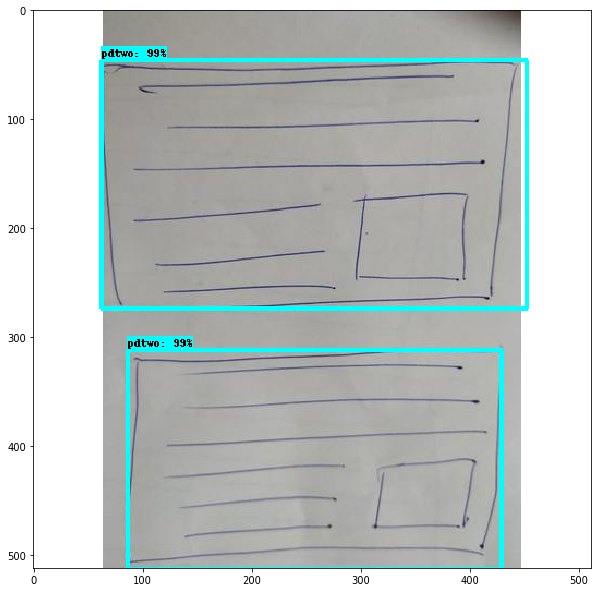

In [41]:
%cd ~/models/research/object_detection
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

#if tf.__version__ < '1.4.0':
 # raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
  

  
  
# This is needed to display the images.
%matplotlib inline




from utils import label_map_util

from utils import visualization_utils as vis_util


MODEL_NAME = 'inference_graph'
CWD_PATH = os.getcwd()


# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(CWD_PATH,'training','labelmap.pbtxt')

NUM_CLASSES = 2




detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)




def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = os.getcwd()
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR,'/root/models/research/object_detection/images/test/design2 (44).jpg') ]
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '.jpg'.format(i)) for i in range(1, 2) ]
# Size, in inches, of the output images.
IMAGE_SIZE = (10, 20)




def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict




for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=4)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import uuid
import numpy as np
import argparse
import imutils
import cv2
from datetime import datetime
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import json
import cv2
import glob
from lxml import etree
import xml.etree.cElementTree as ET
from json2xml import json2xml, readfromurl, readfromstring, readfromjson

sys.path.append("..")

from utils import label_map_util

from utils import visualization_utils as vis_util
from utils import visualization_utils_1 as vis_util_1
from utils import visualization_utils_2 as vis_util_2
from utils import visualization_utils_3 as vis_util_3

MODEL_NAME_1 = 'inference_graph_12'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT_1 = MODEL_NAME_1 + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS_1 = os.path.join('inference_graph_12', 'labelmap.pbtxt')

MODEL_NAME_2 = 'inference_graph_new'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT_2 = MODEL_NAME_2 + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS_2 = os.path.join('inference_graph_14', 'labelmap.pbtxt')

MODEL_NAME_3 = 'inference_graph_13'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT_3 = MODEL_NAME_3 + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS_3 = os.path.join('inference_graph_13', 'labelmap.pbtxt')

# -- doors only

MODEL_NAME_4 = 'inference_graph_new'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT_4 = MODEL_NAME_4 + '/frozen_inference_graph_door.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS_4 = os.path.join('inference_graph_14', 'labelmap.pbtxt')

all_rooms = []
all_windows = []
all_doors = []
all_walls = []

NUM_CLASSES = 90
image = cv2.imread(r'C:\Users\tidyquant\Desktop\000013.jpg')


def correlation(x1, y1, x2,
                y2, x, y):
    if (x > x1 and x < x2 and
            y > y1 and y < y2):
        return True
    else:
        return False


def process_1(image):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT_1, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    label_map = label_map_util.load_labelmap(PATH_TO_LABELS_1)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                                use_display_name=True)

    category_index = label_map_util.create_category_index(categories)

    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:

            image_np = image
            '''image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

            cv2.imshow('fff',image_np)
            cv2.imwrite('f.jpg',image_np)
            cv2.waitKey(0)
            #frame=image_np.copy()'''
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.

            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            print(classes)

            # Visualization of the results of a detection.
            image, box, name = vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,

                # skip_scores=True,
                # skip_labels=True,

                use_normalized_coordinates=True,
                line_thickness=1)

            doors = []
            windows = []
            walls = []
            rooms = []
            height, width, channels = image_np.shape
            for index, value in enumerate(classes[0]):
                if scores[0, index] > 0.0:
                    if ((category_index.get(value)).get("name") == 'door'):
                        print(name)
                        object_dict = {}
                        object_dict["door"] = {}
                        object_dict["door"]["assignedname"] = {}
                        object_dict["door"]["coordinates"] = {}
                        object_dict["door"]["ActualCoordinates"] = {}
                        object_dict["door"]["index"] = (category_index.get(value)).get("id")
                        object_dict["door"]["name"] = (category_index.get(value)).get("name")
                        object_dict["door"]["confidence"] = str(scores[0, index])
                        object_dict["door"]["assignedname"] = name[index]
                        ymin = boxes[0][index][0] * height
                        xmin = boxes[0][index][1] * width
                        ymax = boxes[0][index][2] * height
                        xmax = boxes[0][index][3] * width
                        x = (((xmin) + (xmax)) / 2)
                        y = (((ymin) + (ymax)) / 2)
                        # (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                        #   ymin * im_height, ymax * im_height)
                        # print(left, right, top, bottom)
                        object_dict["door"]["coordinates"]["ymin"] = ymin
                        object_dict["door"]["coordinates"]["xmin"] = xmin
                        object_dict["door"]["coordinates"]["ymax"] = ymax
                        object_dict["door"]["coordinates"]["xmax"] = xmax
                        object_dict["door"]["ActualCoordinates"]["x"] = x
                        object_dict["door"]["ActualCoordinates"]["y"] = y
                        doors.append(object_dict)

            # cv2.rectangle(image_np, (round(right), round(bottom)), (round(left), round(top)), (0, 255, 0), 5)'''

            image_np = imutils.resize(image_np, width=600, height=600)
            cv2.imshow('Recognized Image', image_np)

            cv2.waitKey(000)

            process_4(image, doors)


def process_4(image, doors):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT_4, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    label_map = label_map_util.load_labelmap(PATH_TO_LABELS_4)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                                use_display_name=True)

    category_index = label_map_util.create_category_index(categories)

    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:

            image_np = image
            '''image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

            cv2.imshow('fff',image_np)
            cv2.imwrite('f.jpg',image_np)
            cv2.waitKey(0)
            #frame=image_np.copy()'''
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            # Actual detection.

            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            image, box, name = vis_util_3.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,

                # skip_scores=True,
                # skip_labels=True,

                use_normalized_coordinates=True,
                line_thickness=1)
            print(classes)
            doors_2 = []
            windows = []
            walls = []
            rooms = []
            corr_dorrs = []
            height, width, channels = image_np.shape
            for index, value in enumerate(classes[0]):
                if scores[0, index] > 0.7:
                    if ((category_index.get(value)).get("name") == 'door'):
                        object_dict = {}
                        object_dict["door"] = {}
                        object_dict["door"]["assignedname"] = {}
                        object_dict["door"]["coordinates"] = {}
                        object_dict["door"]["ActualCoordinates"] = {}
                        object_dict["door"]["index"] = (category_index.get(value)).get("id")
                        object_dict["door"]["name"] = (category_index.get(value)).get("name")
                        object_dict["door"]["confidence"] = str(scores[0, index])
                        object_dict["door"]["assignedname"] = name[index]
                        ymin = boxes[0][index][0] * height
                        xmin = boxes[0][index][1] * width
                        ymax = boxes[0][index][2] * height
                        xmax = boxes[0][index][3] * width
                        x = (((xmin) + (xmax)) / 2)
                        y = (((ymin) + (ymax)) / 2)
                        # (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                        #   ymin * im_height, ymax * im_height)
                        # print(left, right, top, bottom)
                        object_dict["door"]["coordinates"]["ymin"] = ymin
                        object_dict["door"]["coordinates"]["xmin"] = xmin
                        object_dict["door"]["coordinates"]["ymax"] = ymax
                        object_dict["door"]["coordinates"]["xmax"] = xmax
                        object_dict["door"]["ActualCoordinates"]["x"] = x
                        object_dict["door"]["ActualCoordinates"]["y"] = y
                        doors_2.append(object_dict)

            for door in doors:
                for doorss in doors_2:
                    ymin = boxes[0][index][0] * height
                    xmin = boxes[0][index][1] * width
                    ymax = boxes[0][index][2] * height
                    xmax = boxes[0][index][3] * width
                    x = (((xmin) + (xmax)) / 2)
                    y = (((ymin) + (ymax)) / 2)
                    res = correlation(door['door']["coordinates"]["xmin"], door['door']["coordinates"]["ymin"],
                                      door['door']["coordinates"]["xmax"], door['door']["coordinates"]["ymax"],
                                      doorss['door']['ActualCoordinates']['x'],
                                      doorss['door']['ActualCoordinates']['y'])
                    print('result', res)
                    if ((res == True)):
                        # if(scores[0, index] > 0.7):
                        # vis_utils_3
                        # print('boxes',scores[0, index])
                        # cv2.rectangle(image_np, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 7)
                        doors_2.remove(doorss)
            for doorsss in doors_2:

                if (float(doorsss["door"]["confidence"]) > 0.7):
                    '''cv2.rectangle(image_np, (
                        int(doorsss["door"]["coordinates"]["xmin"]), int(doorsss["door"]["coordinates"]["ymin"])), (
                                      int(doorsss["door"]["coordinates"]["xmax"]),
                                      int(doorsss["door"]["coordinates"]["ymax"])), (255, 0, 0), 7)'''
                    score = round(float(doorsss["door"]["confidence"]) * 100)
                    '''cv2.putText(image_np, doorsss["door"]["assignedname"] + ':' + str(score) + '%', (
                        int(doorsss["door"]["coordinates"]["xmin"]), int(doorsss["door"]["coordinates"]["ymin"])),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.95, (255, 0, 0), 2, cv2.LINE_AA)'''

            image_np = imutils.resize(image_np, width=600, height=600)
            cv2.imshow('Recognized Image', image_np)
            cv2.waitKey(000)
            corr_dorrs.append(doors)
            corr_dorrs.append(doors_2)
            print('gg', corr_dorrs)

            process_2(image, corr_dorrs)


def process_2(image, corr_dorrs):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT_2, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    label_map = label_map_util.load_labelmap(PATH_TO_LABELS_2)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                                use_display_name=True)

    category_index = label_map_util.create_category_index(categories)

    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:

            image_np = image
            '''image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

                 cv2.imshow('fff',image_np)
                 cv2.imwrite('f.jpg',image_np)
                 cv2.waitKey(0)
                 #frame=image_np.copy()'''
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.

            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            print(classes)

            # Visualization of the results of a detection.
            image, box, name = vis_util_1.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,

                # skip_scores=True,
                # skip_labels=True,

                use_normalized_coordinates=True,
                line_thickness=1)
            print('corrdooors', corr_dorrs)
            doors_2 = []
            windows = []
            walls = []
            rooms = []
            corr_dorrs_2 = []
            height, width, channels = image_np.shape
            try:
              for index, value in enumerate(classes[0]):
                print('name',((category_index.get(value)).get("name")))
                if scores[0, index] > 0.3:
                    if ((category_index.get(value)).get("name") == 'wall'):
                        wall = {}
                        wall["wall"] = {}
                        wall["wall"]["coordinates"] = {}
                        wall["wall"]["assignedname"] = {}
                        wall["wall"]["ActualCoordinates"] = {}
                        wall["wall"]["index"] = (category_index.get(value)).get("id")
                        wall["wall"]["name"] = (category_index.get(value)).get("name")
                        wall["wall"]["confidence"] = str(scores[0, index])
                        wall["wall"]["assignedname"] = name[index]
                        ymin = boxes[0][index][0] * height
                        xmin = boxes[0][index][1] * width
                        ymax = boxes[0][index][2] * height
                        xmax = boxes[0][index][3] * width
                        x = (((xmin) + (xmax)) / 2)
                        y = (((ymin) + (ymax)) / 2)
                        # (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                        #   ymin * im_height, ymax * im_height)
                        # print(left, right, top, bottom)
                        wall["wall"]["coordinates"]["ymin"] = ymin
                        wall["wall"]["coordinates"]["xmin"] = xmin
                        wall["wall"]["coordinates"]["ymax"] = ymax
                        wall["wall"]["coordinates"]["xmax"] = xmax
                        wall["wall"]["ActualCoordinates"]["x"] = x
                        wall["wall"]["ActualCoordinates"]["y"] = y
                        walls.append(wall)
                    if ((category_index.get(value)).get("name") == 'room'):
                        print((category_index.get(value)).get("name"))
                        room = {}
                        room["room"] = {}
                        room["room"]["coordinates"] = {}
                        room["room"]["assignedname"] = {}
                        room["room"]["ActualCoordinates"] = {}
                        room["room"]["index"] = (category_index.get(value)).get("id")
                        room["room"]["name"] = (category_index.get(value)).get("name")
                        room["room"]["confidence"] = str(scores[0, index])
                        room["room"]["assignedname"] = name[index]
                        ymin = boxes[0][index][0] * height
                        xmin = boxes[0][index][1] * width
                        ymax = boxes[0][index][2] * height
                        xmax = boxes[0][index][3] * width
                        # cv2.rectangle(image_np, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 5)
                        x = (((xmin) + (xmax)) / 2)
                        y = (((ymin) + (ymax)) / 2)
                        # (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                        #   ymin * im_height, ymax * im_height)
                        # print(left, right, top, bottom)
                        room["room"]["coordinates"]["ymin"] = ymin
                        room["room"]["coordinates"]["xmin"] = xmin
                        room["room"]["coordinates"]["ymax"] = ymax
                        room["room"]["coordinates"]["xmax"] = xmax
                        room["room"]["ActualCoordinates"]["x"] = x
                        room["room"]["ActualCoordinates"]["y"] = y

                        rooms.append(room)

                    if ((category_index.get(value)).get("name") == 'door'):
                        object_dict = {}
                        object_dict["door"] = {}
                        object_dict["door"]["assignedname"] = {}
                        object_dict["door"]["coordinates"] = {}
                        object_dict["door"]["ActualCoordinates"] = {}
                        object_dict["door"]["index"] = (category_index.get(value)).get("id")
                        object_dict["door"]["name"] = (category_index.get(value)).get("name")
                        object_dict["door"]["confidence"] = str(scores[0, index])
                        object_dict["door"]["assignedname"] = name[index]
                        ymin = boxes[0][index][0] * height
                        xmin = boxes[0][index][1] * width
                        ymax = boxes[0][index][2] * height
                        xmax = boxes[0][index][3] * width
                        x = (((xmin) + (xmax)) / 2)
                        y = (((ymin) + (ymax)) / 2)
                        # (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                        #   ymin * im_height, ymax * im_height)
                        # print(left, right, top, bottom)
                        object_dict["door"]["coordinates"]["ymin"] = ymin
                        object_dict["door"]["coordinates"]["xmin"] = xmin
                        object_dict["door"]["coordinates"]["ymax"] = ymax
                        object_dict["door"]["coordinates"]["xmax"] = xmax
                        object_dict["door"]["ActualCoordinates"]["x"] = x
                        object_dict["door"]["ActualCoordinates"]["y"] = y
                        doors_2.append(object_dict)
            except:
                print('no data')
            for door in corr_dorrs:
                for d in door:
                    for doors in doors_2:
                        print('ddd', door)
                        ymin = boxes[0][index][0] * height
                        xmin = boxes[0][index][1] * width
                        ymax = boxes[0][index][2] * height
                        xmax = boxes[0][index][3] * width
                        x = (((xmin) + (xmax)) / 2)
                        y = (((ymin) + (ymax)) / 2)
                        res = correlation(d['door']["coordinates"]["xmin"], d['door']["coordinates"]["ymin"],
                                          d['door']["coordinates"]["xmax"], d['door']["coordinates"]["ymax"],
                                          doors['door']['ActualCoordinates']['x'],
                                          doors['door']['ActualCoordinates']['y'])
                        print('result', res)
                        if ((res == True)):
                            # if(scores[0, index] > 0.7):
                            # vis_utils_3
                            # print('boxes',scores[0, index])
                            # cv2.rectangle(image_np, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 7)
                            doors_2.remove(doors)
            for doors in doors_2:
                print('doorfull', doors)
                if (float(doors["door"]["confidence"]) > 0.3):
                    '''cv2.rectangle(image_np,
                                  (
                                      int(doors["door"]["coordinates"]["xmin"]),
                                      int(doors["door"]["coordinates"]["ymin"])),
                                  (
                                      int(doors["door"]["coordinates"]["xmax"]),
                                      int(doors["door"]["coordinates"]["ymax"])),
                                  (255, 0, 0), 7)'''
                    score = round(float(doors["door"]["confidence"]) * 100)
                    '''cv2.putText(image_np, doors["door"]["assignedname"] + ':' + str(score) + '%',
                                (int(doors["door"]["coordinates"]["xmin"]), int(doors["door"]["coordinates"]["ymin"])),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.95, (255, 0, 0), 2, cv2.LINE_AA)'''

            image_np = imutils.resize(image_np, width=600, height=600)
            cv2.imshow('Recognized Image', image_np)
            cv2.waitKey(000)
            corr_dorrs_2.append(corr_dorrs)
            corr_dorrs_2.append(doors_2)
            all_rooms.append(rooms)
            print('dddd', all_rooms)
            all_walls.append(walls)
            process_3(image, corr_dorrs_2)


def process_3(image, corr_dorrs_2):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT_3, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    label_map = label_map_util.load_labelmap(PATH_TO_LABELS_3)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                                use_display_name=True)

    category_index = label_map_util.create_category_index(categories)

    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:

            image_np = image
            '''image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

            cv2.imshow('fff',image_np)
            cv2.imwrite('f.jpg',image_np)
            cv2.waitKey(0)
            #frame=image_np.copy()'''
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.

            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            print(classes)

            # Visualization of the results of a detection.
            image, box, name = vis_util_2.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,

                # skip_scores=True,
                # skip_labels=True,

                use_normalized_coordinates=True,
                line_thickness=1)
            doors_2 = []
            windows = []
            walls = []
            rooms = []
            corr_dorrs_3 = []
            height, width, channels = image_np.shape
            for index, value in enumerate(classes[0]):
                if scores[0, index] > 0.0:
                    if ((category_index.get(value)).get("name") == 'wall'):
                        wall = {}
                        wall["wall"] = {}
                        wall["wall"]["coordinates"] = {}
                        wall["wall"]["assignedname"] = {}
                        wall["wall"]["ActualCoordinates"] = {}
                        wall["wall"]["index"] = (category_index.get(value)).get("id")
                        wall["wall"]["name"] = (category_index.get(value)).get("name")
                        wall["wall"]["confidence"] = str(scores[0, index])
                        wall["wall"]["assignedname"] = name[index]
                        ymin = boxes[0][index][0] * height
                        xmin = boxes[0][index][1] * width
                        ymax = boxes[0][index][2] * height
                        xmax = boxes[0][index][3] * width
                        x = (((xmin) + (xmax)) / 2)
                        y = (((ymin) + (ymax)) / 2)
                        # (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                        #   ymin * im_height, ymax * im_height)
                        # print(left, right, top, bottom)
                        wall["wall"]["coordinates"]["ymin"] = ymin
                        wall["wall"]["coordinates"]["xmin"] = xmin
                        wall["wall"]["coordinates"]["ymax"] = ymax
                        wall["wall"]["coordinates"]["xmax"] = xmax
                        wall["wall"]["ActualCoordinates"]["x"] = x
                        wall["wall"]["ActualCoordinates"]["y"] = y
                        walls.append(wall)
                    if ((category_index.get(value)).get("name") == 'window'):
                        window = {}
                        window["window"] = {}
                        window["window"]["coordinates"] = {}
                        window["window"]["assignedname"] = {}
                        window["window"]["ActualCoordinates"] = {}
                        window["window"]["index"] = (category_index.get(value)).get("id")
                        window["window"]["name"] = (category_index.get(value)).get("name")
                        window["window"]["confidence"] = str(scores[0, index])
                        window["window"]["assignedname"] = name[index]

                        ymin = boxes[0][index][0] * height
                        xmin = boxes[0][index][1] * width
                        ymax = boxes[0][index][2] * height
                        xmax = boxes[0][index][3] * width
                        x = (((xmin) + (xmax)) / 2)
                        y = (((ymin) + (ymax)) / 2)
                        # (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                        #   ymin * im_height, ymax * im_height)
                        # print(left, right, top, bottom)
                        window["window"]["coordinates"]["ymin"] = ymin
                        window["window"]["coordinates"]["xmin"] = xmin
                        window["window"]["coordinates"]["ymax"] = ymax
                        window["window"]["coordinates"]["xmax"] = xmax
                        window["window"]["ActualCoordinates"]["x"] = x
                        window["window"]["ActualCoordinates"]["y"] = y

                        windows.append(window)
                    if ((category_index.get(value)).get("name") == 'door'):
                        object_dict = {}
                        object_dict["door"] = {}
                        object_dict["door"]["assignedname"] = {}
                        object_dict["door"]["coordinates"] = {}
                        object_dict["door"]["ActualCoordinates"] = {}
                        object_dict["door"]["index"] = (category_index.get(value)).get("id")
                        object_dict["door"]["name"] = (category_index.get(value)).get("name")
                        object_dict["door"]["confidence"] = str(scores[0, index])
                        object_dict["door"]["assignedname"] = name[index]
                        ymin = boxes[0][index][0] * height
                        xmin = boxes[0][index][1] * width
                        ymax = boxes[0][index][2] * height
                        xmax = boxes[0][index][3] * width
                        x = (((xmin) + (xmax)) / 2)
                        y = (((ymin) + (ymax)) / 2)
                        # (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                        #   ymin * im_height, ymax * im_height)
                        # print(left, right, top, bottom)
                        object_dict["door"]["coordinates"]["ymin"] = ymin
                        object_dict["door"]["coordinates"]["xmin"] = xmin
                        object_dict["door"]["coordinates"]["ymax"] = ymax
                        object_dict["door"]["coordinates"]["xmax"] = xmax
                        object_dict["door"]["ActualCoordinates"]["x"] = x
                        object_dict["door"]["ActualCoordinates"]["y"] = y
                        doors_2.append(object_dict)
            print('pre',corr_dorrs_2)
            print('ddd', doors_2)
            for door in corr_dorrs_2:
                for s in door:
                    for d in s:

                        for doors in doors_2:

                            ymin = boxes[0][index][0] * height
                            xmin = boxes[0][index][1] * width
                            ymax = boxes[0][index][2] * height
                            xmax = boxes[0][index][3] * width
                            x = (((xmin) + (xmax)) / 2)
                            y = (((ymin) + (ymax)) / 2)
                            res = correlation(d['door']["coordinates"]["xmin"], d['door']["coordinates"]["ymin"],
                                              d['door']["coordinates"]["xmax"], d['door']["coordinates"]["ymax"],
                                              doors['door']['ActualCoordinates']['x'],
                                              doors['door']['ActualCoordinates']['y'])
                            print('result', res)
                            if ((res == True)):
                                # if(scores[0, index] > 0.7):
                                # vis_utils_3
                                #print('boxes',scores[0, index])
                                # cv2.rectangle(image_np, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 7)
                                doors_2.remove(doors)
            print('doorfull', doors_2)
            for doors in doors_2:

                if (float(doors["door"]["confidence"]) > 0.0):
                    '''cv2.rectangle(image_np,
                                  (
                                      int(doors["door"]["coordinates"]["xmin"]),
                                      int(doors["door"]["coordinates"]["ymin"])),
                                  (
                                      int(doors["door"]["coordinates"]["xmax"]),
                                      int(doors["door"]["coordinates"]["ymax"])),
                                  (255, 0, 0), 7)'''
                    score = round(float(doors["door"]["confidence"]) * 100)
                    '''cv2.putText(image_np, doors["door"]["assignedname"] + ':' + str(score) + '%',
                                (int(doors["door"]["coordinates"]["xmin"]), int(doors["door"]["coordinates"]["ymin"])),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.95, (255, 0, 0), 2, cv2.LINE_AA)'''

            image_np = imutils.resize(image_np, width=600, height=600)
            cv2.imshow('Recognized Image', image_np)
            cv2.waitKey(000)
            all_doors.append(corr_dorrs_2)
            all_doors.append(doors_2)
            all_windows.append(windows)
            all_walls.append(walls)

            process_5()


def process_5():
    objdoor1 = []
    objdoor1.append(all_doors)
    print('addd',all_doors)
    obj1 = json.dumps(objdoor1)
    print('fffh', obj1)
    data1 = readfromstring(obj1)
    fg = json2xml.Json2xml(data1, wrapper="doors", indent=8).to_xml()
    objwindow2 = []
    objwindow2.append(all_windows)
    obj2 = json.dumps(objwindow2)
    data2 = readfromstring(obj2)
    fgg = json2xml.Json2xml(data2, wrapper="windows", indent=8).to_xml()
    objroom = []
    objwall = []

    objwall.append(all_walls)
    objroom.append(all_rooms)
    obj3 = json.dumps(objwall)
    obj4 = json.dumps(objroom)
    data3 = readfromstring(obj3)
    data4 = readfromstring(obj4)
    fggg = json2xml.Json2xml(data3, wrapper="walls", indent=8).to_xml()
    fgggg = json2xml.Json2xml(data4, wrapper="rooms", indent=8).to_xml()
    corrooms = []
    corrooms = all_rooms.copy()

    corrdoors = []
    corrdoors = all_doors.copy()

    corrwindows = []
    corrwindows = all_windows.copy()
    corrwalls = []
    corrwalls = all_walls.copy()
    roomcorrelations = []
    roomcorrelation = {}
    roomcorrelation["doors"] = {}
    roomcorrelation["windows"] = {}
    roomcorrelation["walls"] = {}
    print('cr', corrdoors)
    print('dr', corrwalls)
    a = 0
    try:
      for index_1 in corrooms:
        for index in index_1:
            for door_3 in corrdoors:

                for door_2 in door_3:
                    for door_1 in door_2:
                        for door in door_1:


                            res = correlation(index['room']["coordinates"]["xmin"],
                                              index['room']["coordinates"]["ymin"],
                                              index['room']["coordinates"]["xmax"],
                                              index['room']["coordinates"]["ymax"],
                                              door['door']['ActualCoordinates']['x'],
                                              door['door']['ActualCoordinates']['y'])
                            if (res == True):
                                roomcorrelation["doors"][a] = {}
                                roomcorrelation["doors"][a]["name"] = door['door']["assignedname"]
                                roomcorrelation["doors"][a]["proomid"] = index['room']["assignedname"]
                                # roomcorrelation["doors"]["proomid"]=index['room']["assignedname"]

                                roomcorrelations.append(roomcorrelation)
                                door_1.remove(door)
                                a = a + 1
    except:
        print('ggg')
    a = 0
    for index in corrooms:
        for index in index_1:
            for door_1 in corrwindows:
                for door in door_1:
                    res = correlation(index['room']["coordinates"]["xmin"], index['room']["coordinates"]["ymin"],
                                      index['room']["coordinates"]["xmax"], index['room']["coordinates"]["ymax"],
                                      door['window']['ActualCoordinates']['x'],
                                      door['window']['ActualCoordinates']['y'])
                    if (res == True):
                        roomcorrelation["windows"][a] = {}
                        roomcorrelation["windows"][a]["name"] = door['window']["assignedname"]
                        roomcorrelation["windows"][a]["proomid"] = index['room']["assignedname"]
                        # roomcorrelation["doors"]["proomid"]=index['room']["assignedname"]

                        # corrdoors.remove(door)
                        roomcorrelations.append(roomcorrelation)
                        door_1.remove(door)
                        a = a + 1
    a = 0
    for index_1 in corrooms:
        for index in index_1:
            for door_1 in corrwalls:
                for door in door_1:
                    res = correlation(index['room']["coordinates"]["xmin"], index['room']["coordinates"]["ymin"],
                                      index['room']["coordinates"]["xmax"], index['room']["coordinates"]["ymax"],
                                      door['wall']['ActualCoordinates']['x'], door['wall']['ActualCoordinates']['y'])
                    if (res == True):
                        roomcorrelation["walls"][a] = {}
                        roomcorrelation["walls"][a]["name"] = door['wall']["assignedname"]
                        roomcorrelation["walls"][a]["proomid"] = index['room']["assignedname"]
                        # roomcorrelation["doors"]["proomid"]=index['room']["assignedname"]

                        # corrdoors.remove(door)
                        roomcorrelations.append(roomcorrelation)
                        door_1.remove(door)
                        a = a + 1




    objcorrelation = []




    objcorrelation.append(roomcorrelation)



    obj5 = json.dumps(objcorrelation)



    data5 = readfromstring(obj5)




    fggggg = json2xml.Json2xml(data5, wrapper="correlations", indent=8).to_xml()
    root = ET.Element("Floorplan")
    tree = ET.ElementTree(root)
    tree.write("demofile3.xml")

    # XML strings to etree
    addressbook_root = etree.fromstring(fg)
    note_root = etree.fromstring(fgg)
    wall_root = etree.fromstring(fggg)
    room_root = etree.fromstring(fgggg)
    correlation_root = etree.fromstring(fggggg)
    newbook_root = etree.parse('demofile3.xml').getroot()
    # append the note
    newbook_root.append(addressbook_root)
    newbook_root.append(note_root)
    newbook_root.append(wall_root)
    newbook_root.append(room_root)
    newbook_root.append(correlation_root)
    # print the new addressbook XML document

    f = open("demofile3.xml", "wb")
    f.write(etree.tostring(newbook_root))
    f.close()
process_1(image)

In [0]:
cd root


In [0]:
ls

In [0]:
#Generate root password
import random, string
password = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(20))

#Download ngrok
! wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -qq -n ngrok-stable-linux-amd64.zip
#Setup sshd
! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null
#Set root password
! echo root:$password | chpasswd
! mkdir -p /var/run/sshd
! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config
! echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config
! echo "LD_LIBRARY_PATH=/usr/lib64-nvidia" >> /root/.bashrc
! echo "export LD_LIBRARY_PATH" >> /root/.bashrc

#Run sshd
get_ipython().system_raw('/usr/sbin/sshd -D &')

#Ask token
print("Copy authtoken from https://dashboard.ngrok.com/auth")
import getpass
authtoken = getpass.getpass()

#Create tunnel
get_ipython().system_raw('./ngrok authtoken $authtoken && ./ngrok tcp 22 &')
#Print root password
print("Root password: {}".format(password))
#Get public address
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"